In [22]:
"""
Copyright 2021 Huawei Technologies Co., Ltd

CREATED:  2020-6-04 20:12:13
MODIFIED: 2021-11-25 11:48:45
"""
import os
import cv2
import numpy as np

# -*- coding:utf-8 -*-
from model.acl import Model
from PIL import Image, ImageDraw, ImageFont

In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
device_id = 7

model1_path = "weights/craft.om"
model2_path = "weights/None-ResNet-None-CTC.om"

image_path = "data/images/test.jpg"
#boxes_path = "data/polygons/res_test_305.txt"

font_path = "data/fonts/OpenSans_Condensed-SemiBold.ttf"

cropped = False
characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
text_thresh = 0.7
link_thresh = 0.4
low_text = 0.4

In [25]:
# load image
img_bgr = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

In [26]:
# model1 load
model1 = Model(device_id, model1_path)
# model2 load
model2 = Model(device_id, model2_path, characters=characters)

[MODEL] create model output dataset:
[MODEL] create model output dataset success
model input size 1
input  0
model input dims ({'name': 'input.1', 'dimCount': 4, 'dims': [1, 3, 800, 1280]}, 0)
model input datatype 0
model output size 1
output  0
model output dims ({'name': 'Transpose_86:0', 'dimCount': 4, 'dims': [1, 400, 640, 2]}, 0)
model output datatype 0
[MODEL] class Model init resource stage success
[MODEL] create model output dataset:
[MODEL] create model output dataset success
model input size 1
input  0
model input dims ({'name': 'input', 'dimCount': 4, 'dims': [1, 1, 32, 100]}, 0)
model input datatype 0
model output size 1
output  0
model output dims ({'name': 'Add_78:0', 'dimCount': 3, 'dims': [1, 26, 37]}, 0)
model output datatype 0
[MODEL] class Model init resource stage success


In [27]:
# model1 run
bboxes = polys = None
bboxes, polys = model1.run(img_rgb, cropped = cropped, text_thresh = text_thresh, link_thresh = link_thresh, low_text = low_text)

[PROCESS] init process success
[PreProc] image_np_expanded shape: (1, 3, 800, 1280)
[ACL] img_host_ptr, img_buf_size:  94192128561168 12288000
[ACL] img_dev_ptr, img_buf_size:  18143032377344 12288000
[MODEL] create model input dataset:
[MODEL] create model input dataset success
[MODEL] execute stage:
[MODEL] execute stage success
[RESULT] infer / postproc time : 0.088 / 0.024


In [28]:
# get coordinates of the boxes and draw on the picture
boxes_coord = []
for poly in polys:
    poly = np.array(poly).astype(np.int32).reshape((-1))
    boxes_coord.append(poly.tolist())
    
    poly = poly.reshape(-1, 2)
    cv2.polylines(img_bgr, [poly.reshape((-1, 1, 2))], True, color=(0, 0, 255), thickness=2)
    
print(boxes_coord)

[[229, 54, 367, 47, 368, 77, 230, 84], [78, 220, 156, 218, 156, 235, 78, 237], [117, 237, 122, 237, 126, 237, 131, 237, 135, 237, 142, 237, 146, 237, 144, 246, 140, 246, 136, 246, 131, 246, 126, 246, 122, 247, 117, 247], [145, 238, 150, 238, 150, 246, 145, 246], [84, 238, 115, 238, 115, 248, 84, 248]]


In [29]:
# # show score text
# img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
# img_rgb_plw = Image.fromarray(img_rgb)
# img_rgb_plw

In [30]:
# # load boxes from text file(if you have two network, skip this step)
# vertical_positions = None
# with open(boxes_path, 'r') as bbox_f: # read coordinates of extracted bounding boxes from text file
#     box_coords = [line.rstrip('\n') for line in bbox_f]
# vertical_positions = np.argsort(np.asarray([int(y0.split(',')[1]) for y0 in box_coords]))

# boxes_coord = []
# for i in vertical_positions:
#     line = box_coords[i]
#     boxes_coord.append([int(i) for i in line.split(',')])
    
# print(boxes_coord)

In [31]:
# model2 run
bboxes = None
bboxes = model2.run(img_bgr, cropped = cropped, boxes_coord = boxes_coord)

[PROCESS] init process success
[INFO] recognizing texts . . .
[INFO] loading text boxes . . .
[INFO]  5 text boxes found.
[PreProc] image_np_expanded shape: (1, 1, 32, 100)
[ACL] img_host_ptr, img_buf_size:  94192122088768 12800
[ACL] img_dev_ptr, img_buf_size:  18143025774592 12800
[MODEL] create model input dataset:
[MODEL] create model input dataset success
[MODEL] execute stage:
[MODEL] execute stage success
[PreProc] image_np_expanded shape: (1, 1, 32, 100)
[ACL] img_host_ptr, img_buf_size:  94192122088768 12800
[ACL] img_dev_ptr, img_buf_size:  18143025774592 12800
[MODEL] create model input dataset:
[MODEL] create model input dataset success
[MODEL] execute stage:
[MODEL] execute stage success
[PreProc] image_np_expanded shape: (1, 1, 32, 100)
[ACL] img_host_ptr, img_buf_size:  94192122088768 12800
[ACL] img_dev_ptr, img_buf_size:  18143025774592 12800
[MODEL] create model input dataset:
[MODEL] create model input dataset success
[MODEL] execute stage:
[MODEL] execute stage succ

In [32]:
# get results
img_rgb_plw = Image.fromarray(img_rgb)
s = draw = None
draw = ImageDraw.Draw(img_rgb_plw)
font = ImageFont.truetype(font_path, 18)
s = ""

for b in bboxes:
    points = b.get_points()
    arry_points = tuple(map(tuple, np.array(points).astype("int32").reshape([-1, int(len(points) / 2), 2])[0]))
    draw.polygon(arry_points, outline="red")
    draw.text((points[0], points[1]-20), b.get_text(), font=font, fill='green')
    s+=b.get_text() + " "

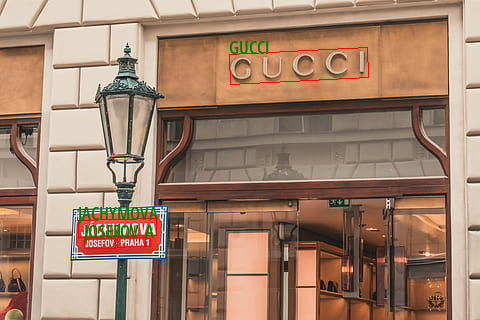

In [33]:
# show outputs
img_rgb_plw

In [34]:
# show output texts
print("[Result] image texts :", s)

[Result] image texts : GUCCI JACHYMOVA I JOSEFOV A 
